<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span><ul class="toc-item"><li><span><a href="#Объявление-функций" data-toc-modified-id="Объявление-функций-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Объявление функций</a></span></li><li><span><a href="#Распределение-типов-переменных" data-toc-modified-id="Распределение-типов-переменных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Распределение типов переменных</a></span></li></ul></li><li><span><a href="#Очистка-датасета" data-toc-modified-id="Очистка-датасета-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Очистка датасета</a></span><ul class="toc-item"><li><span><a href="#Отбираем-кат-признаки" data-toc-modified-id="Отбираем-кат-признаки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Отбираем кат признаки</a></span></li><li><span><a href="#Отбираем-числовые-признаки" data-toc-modified-id="Отбираем-числовые-признаки-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Отбираем числовые признаки</a></span></li><li><span><a href="#Получившиеся-фичи" data-toc-modified-id="Получившиеся-фичи-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Получившиеся фичи</a></span></li></ul></li><li><span><a href="#get_features_importances" data-toc-modified-id="get_features_importances-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>get_features_importances</a></span><ul class="toc-item"><li><span><a href="#Downsample" data-toc-modified-id="Downsample-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Downsample</a></span><ul class="toc-item"><li><span><a href="#Обычная-модель" data-toc-modified-id="Обычная-модель-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Обычная модель</a></span></li><li><span><a href="#GridSearchCV" data-toc-modified-id="GridSearchCV-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>GridSearchCV</a></span></li><li><span><a href="#feature_importance" data-toc-modified-id="feature_importance-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>feature_importance</a></span></li></ul></li><li><span><a href="#class_weight-=-'balanced'" data-toc-modified-id="class_weight-=-'balanced'-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>class_weight = 'balanced'</a></span><ul class="toc-item"><li><span><a href="#Обычная-модель" data-toc-modified-id="Обычная-модель-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Обычная модель</a></span></li><li><span><a href="#GridSearchCV" data-toc-modified-id="GridSearchCV-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>GridSearchCV</a></span></li><li><span><a href="#feature_importnace" data-toc-modified-id="feature_importnace-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>feature_importnace</a></span></li></ul></li><li><span><a href="#Отбираем-признаки" data-toc-modified-id="Отбираем-признаки-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Отбираем признаки</a></span></li></ul></li></ul></div>

# Отбор значимых непрерывных признаков

## Обзор данных

In [48]:
# импорт основных библиотек
import pandas as pd
import numpy as np

# импорт библиотек текущего модуля
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    confusion_matrix
)
from sklearn.utils import resample
from scipy.stats import pointbiserialr

# настройки
pd.set_option('display.max_columns', 100)

# пути
dataset_train_path = '../../data/dataset_train.parquet'
dataset_test_path = '../../data/features_oot.parquet'
features_types_path = '../../data/features_types.json'
sample_submission_path = '../../data/sample_submission.csv'

# константы
RANDOM_STATE = 42


### Объявление функций

In [2]:
def read_data(path: str, left: int, right: int):
    """
    Функция для считывания определенного количества столбцов из parquet файла.
    ---
    Принимает на вход str путь к файлу, int левую и int правую границу.
    Столбец с таргетом добавляется в конец автоматически!
    Функция возвращает pd.DataFrame.
    """
    # следующие т столбцов, которые будем считывать + target
    columns_to_read = features_types['feature'][left:right].to_list() + ['channel_name'] + ['target']

    # считываем столбцы в файл
    data = pd.read_parquet(path, engine='pyarrow', columns=columns_to_read)

    return data


def variance_filter(data: pd.DataFrame, threshold: float):
    """
    Функция для проверки датасета на наличие константных (или около того) значений.
    ---
    Принимает на вход pd.DataFrame и float с значением порога для дисперсии.
    Функция возвращает отфильтрованный pd.DataFrame.
    """
    # порог для дисперсии
    threshold = threshold

    # считаем дисперсию для каждого признака
    variance = data.iloc[:, :-1].var()

    # отбираем те фичи, у которых var > threshold
    selected_features = variance[variance > threshold].index.tolist()

    # собираем в датасет
    filtered_data = data[selected_features + ['target']]
    
    return filtered_data
    

def check_corr_biserial(data: pd.DataFrame):
    """
    Функция для расчета коэф. корреляции бисериального всех признаков с целевой переменной.
    ---
    Принимает на вход pd.DataFrame.
    Возвращает pd.Series с значением коэффициента корреляции бисериального для каждого признака.
    """
    # все признаки, кроме последнего столбца с целевой переменной
    features = data.iloc[:, :-1]

    # пустой словарь для хранения результатов
    correlations = {}

    # проходимся по каждому признаку и вычисляем коэффициент корреляции
    for feature_name in features.columns:
        feature = data[feature_name]
        target = data['target']
        correlation, p_value = pointbiserialr(feature, target)
        correlations[feature_name] = correlation

    # создаем DataFrame из словаря корреляций
    correlation = pd.DataFrame.from_dict(correlations, orient='index', columns=['point_biserial_correlation'])
    
    # сортируем
    correlation = correlation.sort_values(by='point_biserial_correlation', ascending=False)
    
    return correlation
    
    
def check_corr_pearson(data: pd.DataFrame):
    """
    Функция для расчета корреляции Пирсона всех признаков с целевой переменной.
    ---
    Принимает на вход pd.DataFrame.
    Возвращает pd.Series с значением коэффициента корреляции для каждого признака.
    """
    # чекаем корреляцию с таргетом
    correlation = data.iloc[:, :-1].corrwith(data['target'])
    
    # сортируем
    correlation = correlation.sort_values(ascending=False)
    
    return correlation


def reshape_corr_matrix(data: pd.DataFrame):
    """
    Функция для преобразования вида корреляционной матрицы
    ---
    Принимает на вход pd.DataFrame (корр. матрицу)
    Возвращает pd.DataFrame со столбцами: ['feature_1', 'feature_2', 'corr']
    """
    # создаем пустой df
    reshaped_data = pd.DataFrame()
    
    # в цикле преобразовываем данные
    for feature in data.columns:    
        temp_data = data[feature] \
            .reset_index() \
            .rename(columns={'index': 'feature_1', feature: 'corr'})
    
        temp_data['feature_2'] = feature
    
        reshaped_data = pd.concat([reshaped_data, temp_data])
    
    # меняем порядок столбцов
    reshaped_data = reshaped_data[['feature_1', 'feature_2', 'corr']]
    
    # выводим результат
    return reshaped_data

### Распределение типов переменных

In [3]:
# читаем файлы
features_types = pd.read_json(features_types_path, orient='index')
sample_submission = pd.read_csv(sample_submission_path)


In [4]:
sample_submission.head()

,id,target
0,0,0.343518
1,1,0.591216
2,2,0.913150
3,3,0.560035
4,4,0.352795


In [5]:
# приводим features_types к читаемому виду
features_types = features_types \
    .reset_index() \
    .rename(columns={'index': 'feature', 0: 'type'})

# выводим на экран
features_types


,feature,type
0,markers_0_1_cnt,numeric
1,markers_1_1_cnt,numeric
2,markers_2_1_cnt,numeric
3,markers_3_1_cnt,numeric
4,markers_4_1_cnt,numeric
...,...,...
2771,markers_941_1_cnt,numeric
2772,markers_942_1_cnt,numeric
2773,markers_943_1_cnt,numeric
2774,markers_944_1_cnt,numeric


In [6]:
# распределение типов данных
features_types.type.value_counts()


type
numeric            2607
categorical_int     138
categorical_str      31
Name: count, dtype: int64

In [7]:
# смотрим на все фичи в паркете
print(features_types['feature'].to_list())


['markers_0_1_cnt', 'markers_1_1_cnt', 'markers_2_1_cnt', 'markers_3_1_cnt', 'markers_4_1_cnt', 'markers_5_1_cnt', 'markers_6_1_cnt', 'markers_7_1_cnt', 'markers_8_1_cnt', 'markers_9_1_cnt', 'markers_10_1_cnt', 'markers_11_1_cnt', 'markers_12_1_cnt', 'markers_13_1_cnt', 'markers_14_1_cnt', 'markers_15_1_cnt', 'markers_16_1_cnt', 'markers_17_1_cnt', 'markers_18_1_cnt', 'markers_19_1_cnt', 'markers_20_1_cnt', 'markers_21_1_cnt', 'markers_22_1_cnt', 'markers_23_1_cnt', 'markers_24_1_cnt', 'markers_25_1_cnt', 'markers_26_1_cnt', 'markers_27_1_cnt', 'markers_28_1_cnt', 'markers_29_1_cnt', 'markers_30_1_cnt', 'markers_31_1_cnt', 'markers_32_1_cnt', 'markers_33_1_cnt', 'markers_34_1_cnt', 'markers_35_1_cnt', 'markers_36_1_cnt', 'markers_37_1_cnt', 'markers_38_1_cnt', 'markers_39_1_cnt', 'markers_40_1_cnt', 'markers_41_1_cnt', 'markers_42_1_cnt', 'markers_43_1_cnt', 'markers_44_1_cnt', 'markers_45_1_cnt', 'markers_46_1_cnt', 'markers_47_1_cnt', 'markers_48_1_cnt', 'markers_49_1_cnt', 'markers_

## Очистка датасета

In [8]:
# считаем файл
dataset_train = read_data(dataset_train_path, 0, 930)
# dataset_test = pd.read_parquet(dataset_test_path, engine='pyarrow')

### Отбираем кат признаки

In [10]:
# получим список кат фичей
cat_features = []

for feature in dataset_train.columns[:-2]:
    if feature.split('_')[-1] in ['flg', 'ctg', 'channel_name', 'src_id']:
        cat_features.append(feature)
        
cat_features

['materials_details_0_1_ctg',
 'communication_availability_0_1_flg',
 'communication_availability_1_1_ctg',
 'communication_availability_2_1_flg',
 'materials_details_1_1_ctg',
 'user_lifetime_0_1_ctg',
 'user_lifetime_1_1_flg',
 'communication_availability_3_1_flg',
 'materials_details_5_1_flg',
 'materials_details_7_1_flg',
 'materials_details_8_1_flg']

In [11]:
dataset_train[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 11 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   materials_details_0_1_ctg           702086 non-null  int64
 1   communication_availability_0_1_flg  702086 non-null  int32
 2   communication_availability_1_1_ctg  702086 non-null  int32
 3   communication_availability_2_1_flg  702086 non-null  int32
 4   materials_details_1_1_ctg           702086 non-null  int64
 5   user_lifetime_0_1_ctg               702086 non-null  int64
 6   user_lifetime_1_1_flg               702086 non-null  int32
 7   communication_availability_3_1_flg  702086 non-null  int32
 8   materials_details_5_1_flg           702086 non-null  int8 
 9   materials_details_7_1_flg           702086 non-null  int8 
 10  materials_details_8_1_flg           702086 non-null  int8 
dtypes: int32(5), int64(3), int8(3)
memory usage: 31.5 MB

In [12]:
# считаем корреляцию кт признаков между собой
cat_corr = dataset_train[cat_features].corr(method='spearman')

# удаляем категориальные признаки, которые сильно коррелируют друг с другом
cat_corr_reshaped = reshape_corr_matrix(cat_corr)

features_to_delete = cat_corr_reshaped \
    .query('corr != 1 and corr > 0.5') \
    .sort_values(by='corr', ascending=False)

features_to_delete

,feature_1,feature_2,corr
10,materials_details_8_1_flg,materials_details_7_1_flg,0.995847
9,materials_details_7_1_flg,materials_details_8_1_flg,0.995847
10,materials_details_8_1_flg,materials_details_5_1_flg,0.995015
8,materials_details_5_1_flg,materials_details_8_1_flg,0.995015
9,materials_details_7_1_flg,materials_details_5_1_flg,0.992070
8,materials_details_5_1_flg,materials_details_7_1_flg,0.992070
6,user_lifetime_1_1_flg,user_lifetime_0_1_ctg,0.977829
5,user_lifetime_0_1_ctg,user_lifetime_1_1_flg,0.977829
7,communication_availability_3_1_flg,communication_availability_0_1_flg,0.600903
1,communication_availability_0_1_flg,communication_availability_3_1_flg,0.600903


In [13]:
# отбираем кат признаки
cat_features = [
    'materials_details_8_1_flg',
    'user_lifetime_1_1_flg',
    'communication_availability_3_1_flg',
    'materials_details_1_1_ctg',
    'materials_details_0_1_ctg',
    'channel_name'
]

dataset_train[cat_features].corrwith(dataset_train.target, method='spearman').sort_values(ascending=False)

materials_details_8_1_flg             0.011134
communication_availability_3_1_flg    0.005204
user_lifetime_1_1_flg                 0.003914
materials_details_1_1_ctg            -0.002907
materials_details_0_1_ctg            -0.019734
channel_name                         -0.021708
dtype: float64

### Отбираем числовые признаки

In [14]:
# теперь отберем числовые признаки
num_features = []

for feature in dataset_train.columns[:-2]:
    if feature.split('_')[-1] in ['num', 'sum', 'avg', 'cnt', 'sumpct', 'part']:
        num_features.append(feature)
        
len(num_features)

910

Итого имеем отдельно категориальные и чистовые признаки!

Удалим столбцы в которых много пропусков.

In [15]:
# удалим столбцы где много пропусков
dataset_num = dataset_train[num_features + ['target']].dropna(axis=1, thresh=dataset_train.shape[0]/2)
dataset_num = dataset_num.dropna(axis=0, thresh=dataset_num.shape[1]/2)
dataset_num.shape

(671264, 875)

Теперь очистим числовые признаки с помощью дисперсии и корреляции

In [16]:
# убираем константные столбцы
dataset_num = variance_filter(dataset_num, 0.5)
dataset_num.shape

(671264, 852)

In [17]:
# перезаписали
num_features = list(dataset_num.columns[:-1])

Теперь проведем корр анализ и также уберем лишние признаки

In [18]:
try:
    data_corr = pd.read_csv('../../data/data_corr.csv', index_col='Unnamed: 0')
except:
    data_corr = dataset_train[num_features].corr()

In [19]:
# приводим в должный вид
reshaped_corr_matrix = reshape_corr_matrix(data_corr)

In [20]:
reshaped_corr_matrix \
    .query('corr != 1.0 and corr > 0.75') \
    .sort_values(by='corr', ascending=False)

,feature_1,feature_2,corr
803,charges_details_8_6_avg,charges_details_11_6_avg,0.999999
806,charges_details_11_6_avg,charges_details_8_6_avg,0.999999
820,charges_details_23_6_avg,charges_details_26_6_avg,0.999999
823,charges_details_26_6_avg,charges_details_23_6_avg,0.999999
805,charges_details_10_3_avg,charges_details_7_3_avg,0.999999
...,...,...,...
471,markers_509_1_cnt,markers_281_1_cnt,0.751511
679,markers_734_1_cnt,markers_530_1_cnt,0.751121
491,markers_530_1_cnt,markers_734_1_cnt,0.751121
843,plan_costs_4_3_avg,payments_details_50_6_sum,0.750002


In [21]:
features_to_delete = reshaped_corr_matrix \
    .query('corr != 1.0 and corr > 0.75') \
    .sort_values(by='corr', ascending=False) \
    .iloc[::2, 1].to_list()

len(features_to_delete)

287

In [22]:
dataset_num = dataset_num.drop(features_to_delete, axis=1)
dataset_num.shape

(671264, 761)

In [23]:
# опять перезапишем
num_features = list(dataset_num.columns[:-1])

### Получившиеся фичи

In [26]:
my_test_features = num_features + cat_features + ['target']
len(my_test_features)

767

In [28]:
dataset_train = dataset_train[my_test_features]
dataset_train.head()

,markers_0_1_cnt,markers_1_1_cnt,markers_2_1_cnt,markers_3_1_cnt,markers_4_1_cnt,markers_5_1_cnt,markers_6_1_cnt,markers_7_1_cnt,markers_8_1_cnt,markers_9_1_cnt,markers_10_1_cnt,markers_11_1_cnt,markers_12_1_cnt,markers_13_1_cnt,markers_14_1_cnt,markers_15_1_cnt,markers_16_1_cnt,markers_17_1_cnt,markers_18_1_cnt,markers_19_1_cnt,markers_20_1_cnt,markers_21_1_cnt,markers_22_1_cnt,markers_24_1_cnt,markers_25_1_cnt,markers_26_1_cnt,markers_27_1_cnt,markers_28_1_cnt,markers_29_1_cnt,markers_30_1_cnt,markers_31_1_cnt,markers_32_1_cnt,markers_33_1_cnt,markers_34_1_cnt,markers_35_1_cnt,markers_36_1_cnt,markers_37_1_cnt,markers_38_1_cnt,markers_39_1_cnt,markers_40_1_cnt,markers_41_1_cnt,markers_42_1_cnt,markers_43_1_cnt,markers_44_1_cnt,markers_45_1_cnt,markers_46_1_cnt,markers_47_1_cnt,markers_48_1_cnt,markers_49_1_cnt,markers_50_1_cnt,...,markers_786_1_cnt,markers_787_1_cnt,markers_788_1_cnt,markers_789_1_cnt,markers_790_1_cnt,markers_791_1_cnt,markers_793_1_cnt,markers_794_1_cnt,markers_795_1_cnt,markers_796_1_cnt,markers_797_1_cnt,markers_798_1_cnt,markers_799_1_cnt,markers_800_1_cnt,markers_801_1_cnt,markers_802_1_cnt,markers_803_1_cnt,markers_804_1_cnt,markers_805_1_cnt,payments_details_5_6_cnt,payments_details_10_3_cnt,payments_details_16_1d3_avg,payments_details_23_3d6_avg,payments_details_24_3d6_cnt,payments_details_27_1_sumpct,payments_details_29_6_sumpct,user_devices_0_1_cnt,user_devices_1_1_cnt,user_devices_2_1_cnt,balance_details_0_1_num,charges_details_14_6_avg,charges_details_16_3_avg,charges_details_20_6_avg,payments_details_30_1_sum,payments_details_34_3_sum,payments_details_39_1_sum,payments_details_41_6_sum,payments_details_46_1_sum,payments_details_47_3_avg,payments_details_48_3_sum,payments_details_49_6_avg,plan_costs_7_3_avg,charges_details_31_3_avg,materials_details_8_1_flg,user_lifetime_1_1_flg,communication_availability_3_1_flg,materials_details_1_1_ctg,materials_details_0_1_ctg,channel_name,target
0,-0.149534,-0.096585,-0.400870,-0.362458,0.302917,-0.324892,-0.046691,-0.554345,-0.016534,-0.05408,-0.044653,-0.208968,-0.017454,-0.008052,-0.028391,-0.031395,-0.199957,-0.064366,-0.026839,-0.027484,-0.03147,-0.080534,-0.110653,-0.02527,-0.115151,-0.04685,-0.033911,-0.00794,-0.025816,-0.088375,-0.009532,-0.237766,-0.041626,-0.012926,-0.028445,-0.009258,-0.026347,-0.038496,-0.089040,-0.401337,-0.03564,-0.100471,-0.035238,-0.009976,-0.031354,-0.006144,-0.070189,-0.047567,-0.050881,-0.190083,...,-0.116006,-0.06547,-0.206636,-0.212451,-0.009755,-0.111689,-0.117005,-0.093901,-0.033756,-0.187771,-0.0051,-0.00963,-0.007384,-0.011695,-0.065081,-0.009588,-0.020736,-0.149392,-0.3601,0.404608,-0.007544,0.358846,0.172597,-0.107577,-0.316965,-0.722535,-0.310186,-0.03573,-0.039662,-0.067160,-0.857056,-1.986848,1.426084,-0.396153,-0.481712,-0.00359,-0.005738,-0.664550,-0.790306,-1.139354,-0.790365,-0.000272,-0.202053,-1,-1,1,1,1,5,0
1,-0.149534,-0.096585,0.196468,-0.362458,0.092276,-0.324892,-0.046691,-0.554345,-0.016534,-0.05408,-0.044653,-0.208968,-0.017454,-0.008052,-0.028391,-0.031395,-0.199957,-0.064366,-0.026839,-0.027484,-0.03147,-0.080534,-0.110653,-0.02527,-0.115151,-0.04685,-0.033911,-0.00794,-0.025816,-0.088375,-0.009532,-0.237766,-0.041626,-0.012926,-0.028445,-0.009258,-0.026347,-0.038496,-0.089040,-0.401337,-0.03564,-0.100471,-0.035238,-0.009976,-0.031354,-0.006144,-0.070189,-0.047567,-0.050881,-0.190083,...,-0.116006,-0.06547,-0.206636,-0.212451,-0.009755,-0.111689,-0.117005,-0.093901,-0.033756,-0.187771,-0.0051,-0.00963,-0.007384,-0.011695,-0.065081,-0.009588,-0.020736,-0.149392,-0.3601,0.160109,-0.007544,-2.358446,-0.006716,-0.775059,-1.659485,-1.354314,-0.310186,-0.03573,-0.039662,-0.490323,-0.857056,-2.105466,1.609937,-0.396153,-0.768797,-0.00359,-0.005738,-1.282044,-0.790306,-1.486744,-0.767356,-0.271995,-0.202053,-1,-1,1,1,1,5,0
2,-0.149534,-0.096585,-0.102201,0.911996,0.724200,0.445189,-0.046691,-0.397624,-0.016534,-0.05408,-0.044653,-0.208968,-0.017454,-0.008052,-0.028391,-0.031395,-0.199957,-0.064366,-0.026

## get_features_importances

Приступим к анализу feature_importance

In [29]:
dataset_train['target'].value_counts()

target
0    696617
1      5469
Name: count, dtype: int64

### Downsample

In [30]:
dataset_train['channel_name'] = dataset_train['channel_name'].astype('int')

In [31]:
data_1 = dataset_train[dataset_train["target"] == 1]
data_0 = dataset_train[dataset_train["target"] == 0]

print(data_1.shape)
print(data_0.shape)

(5469, 767)
(696617, 767)


In [32]:
data_0_downsampled = resample(
    data_0,
    replace=True,
    n_samples=len(data_1),
    random_state=RANDOM_STATE
)

print(data_0_downsampled.shape)

(5469, 767)


In [33]:
data_downsampled = pd.concat([data_0_downsampled, data_1])

print(data_downsampled["target"].value_counts())

target
0    5469
1    5469
Name: count, dtype: int64


In [34]:
X_downsampled = data_downsampled.iloc[:, :-1]
y_downsampled = data_downsampled['target']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_downsampled, y_downsampled, test_size=0.25, stratify=y_downsampled, random_state=RANDOM_STATE
)

#### Обычная модель

In [35]:
%%time

# модель
lgbm_model = LGBMClassifier(
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

# fit predict
lgbm_model.fit(
    X_train_d, y_train_d,
    eval_set=[(X_test_d, y_test_d)],
    eval_metric='roc_auc',
    categorical_feature=cat_features
)

y_pred_proba = lgbm_model.predict_proba(X_test_d)
y_pred = lgbm_model.predict(X_test_d)

# скоры
roc_score = roc_auc_score(y_test_d, y_pred_proba[:,1])
gini_score = (2 * roc_score) - 1
acc_score = accuracy_score(y_test_d, y_pred)

# выводим информацию на экран
print(f'LGBM ROC AUC SCORE: {roc_score:.2f}')
print(f'LGBM GINI SCORE: {gini_score:.2f}')
print(f'LGBM ACCURACY SCORE: {acc_score:.2f}')
print('-' * 25)

C:\Users\Nikolaj\anaconda3\envs\hackaton-r1\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Nikolaj\anaconda3\envs\hackaton-r1\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['channel_name', 'communication_availability_3_1_flg', 'materials_details_0_1_ctg', 'materials_details_1_1_ctg', 'materials_details_8_1_flg', 'user_lifetime_1_1_flg']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\Nikolaj\anaconda3\envs\hackaton-r1\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Nikolaj\anaconda3\envs\hackaton-r1\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param d

[1]	valid_0's binary_logloss: 0.679137
[2]	valid_0's binary_logloss: 0.667631
[3]	valid_0's binary_logloss: 0.65868
[4]	valid_0's binary_logloss: 0.650906
[5]	valid_0's binary_logloss: 0.644819
[6]	valid_0's binary_logloss: 0.639283
[7]	valid_0's binary_logloss: 0.634448
[8]	valid_0's binary_logloss: 0.631157
[9]	valid_0's binary_logloss: 0.628619
[10]	valid_0's binary_logloss: 0.625988
[11]	valid_0's binary_logloss: 0.624641
[12]	valid_0's binary_logloss: 0.623591
[13]	valid_0's binary_logloss: 0.622045
[14]	valid_0's binary_logloss: 0.621131
[15]	valid_0's binary_logloss: 0.619929
[16]	valid_0's binary_logloss: 0.619448
[17]	valid_0's binary_logloss: 0.619169
[18]	valid_0's binary_logloss: 0.61932
[19]	valid_0's binary_logloss: 0.618236
[20]	valid_0's binary_logloss: 0.617494
[21]	valid_0's binary_logloss: 0.616772
[22]	valid_0's binary_logloss: 0.616793
[23]	valid_0's binary_logloss: 0.617176
[24]	valid_0's binary_logloss: 0.616405
[25]	valid_0's binary_logloss: 0.615454
[26]	valid_

#### GridSearchCV

In [ ]:
%%time

# задаем сетку параметров
param_grid_lgbm = {
    'n_estimators': range(100, 1001, 100),
    'max_depth': range(1, 5, 1),
    'learning_rate': [0.01, 0.05, 0.1]
}

# описываем gs
gs_lgbm_pl = GridSearchCV(
    lgbm_model, 
    param_grid=param_grid_lgbm, 
    scoring='roc_auc', 
    n_jobs=-1,
    cv=5
)

# фиттим модель
gs_lgbm_pl.fit(
    X_train_d, y_train_d,
    eval_set=[(X_test_d, y_test_d)],
    eval_metric='roc_auc',
    categorical_feature=cat_features
)

# сохраняем лучший скор и параметры
gs_lgbm_best_score = gs_lgbm_pl.best_score_
gs_lgbm_best_params = gs_lgbm_pl.best_params_


# выводим информацию на экран
print(f'LGBM BEST ROC AUC SCORE: {gs_lgbm_best_score:.2f}')
print(f'LGBM BEST PARAMS: {gs_lgbm_best_params}')
print('-' * 93)

#### feature_importance

In [36]:
# Получите важности признаков
feature_importance = lgbm_model.feature_importances_

# Создайте DataFrame с названиями признаков и их важностями
downsample_importance_df = pd.DataFrame({'feature': X_train_d.columns, 'importance': feature_importance})

# Отсортируйте по убыванию важности
downsample_importance_df = downsample_importance_df.sort_values('importance', ascending=False)

# Выведите результаты
downsample_importance_df.head(30)


,feature,importance
757,payments_details_49_6_avg,72
748,charges_details_16_3_avg,71
742,payments_details_29_6_sumpct,66
756,payments_details_48_3_sum,58
747,charges_details_14_6_avg,53
642,markers_706_1_cnt,47
279,markers_310_1_cnt,45
315,markers_349_1_cnt,43
741,payments_details_27_1_sumpct,43
751,payments_details_34_3_sum,42


### class_weight = 'balanced'

In [37]:
X = dataset_train.iloc[:, :-1]
y = dataset_train['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

#### Обычная модель

In [45]:
%%time

# модель
lgbm_model = LGBMClassifier(
    learning_rate=0.05,
    n_estimators=500,
    max_depth=3,
    n_jobs=-1, 
    class_weight='balanced', 
    random_state=RANDOM_STATE
)

# fit predict
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='roc_auc',
    categorical_feature=cat_features
)

y_pred_proba = lgbm_model.predict_proba(X_test)
y_pred = lgbm_model.predict(X_test)

# скоры
roc_score = roc_auc_score(y_test, y_pred_proba[:,1])
gini_score = (2 * roc_score) - 1
acc_score = accuracy_score(y_test, y_pred)

# выводим информацию на экран
print(f'LGBM ROC AUC SCORE: {roc_score:.2f}')
print(f'LGBM GINI SCORE: {gini_score:.2f}')
print(f'LGBM ACCURACY SCORE: {acc_score:.2f}')
print('-' * 25)

C:\Users\Nikolaj\anaconda3\envs\hackaton-r1\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Nikolaj\anaconda3\envs\hackaton-r1\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['channel_name', 'communication_availability_3_1_flg', 'materials_details_0_1_ctg', 'materials_details_1_1_ctg', 'materials_details_8_1_flg', 'user_lifetime_1_1_flg']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\Nikolaj\anaconda3\envs\hackaton-r1\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Nikolaj\anaconda3\envs\hackaton-r1\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param d

[1]	valid_0's binary_logloss: 0.68597
[2]	valid_0's binary_logloss: 0.679489
[3]	valid_0's binary_logloss: 0.673647
[4]	valid_0's binary_logloss: 0.668367
[5]	valid_0's binary_logloss: 0.663558
[6]	valid_0's binary_logloss: 0.659199
[7]	valid_0's binary_logloss: 0.655244
[8]	valid_0's binary_logloss: 0.651637
[9]	valid_0's binary_logloss: 0.64833
[10]	valid_0's binary_logloss: 0.645303
[11]	valid_0's binary_logloss: 0.642513
[12]	valid_0's binary_logloss: 0.63994
[13]	valid_0's binary_logloss: 0.637592
[14]	valid_0's binary_logloss: 0.635366
[15]	valid_0's binary_logloss: 0.63334
[16]	valid_0's binary_logloss: 0.631458
[17]	valid_0's binary_logloss: 0.629727
[18]	valid_0's binary_logloss: 0.628092
[19]	valid_0's binary_logloss: 0.626584
[20]	valid_0's binary_logloss: 0.625244
[21]	valid_0's binary_logloss: 0.623882
[22]	valid_0's binary_logloss: 0.622665
[23]	valid_0's binary_logloss: 0.621497
[24]	valid_0's binary_logloss: 0.620428
[25]	valid_0's binary_logloss: 0.619456
[26]	valid_0'

[204]	valid_0's binary_logloss: 0.575021
[205]	valid_0's binary_logloss: 0.574965
[206]	valid_0's binary_logloss: 0.574887
[207]	valid_0's binary_logloss: 0.574822
[208]	valid_0's binary_logloss: 0.57469
[209]	valid_0's binary_logloss: 0.574546
[210]	valid_0's binary_logloss: 0.574353
[211]	valid_0's binary_logloss: 0.574253
[212]	valid_0's binary_logloss: 0.574192
[213]	valid_0's binary_logloss: 0.574072
[214]	valid_0's binary_logloss: 0.57392
[215]	valid_0's binary_logloss: 0.573786
[216]	valid_0's binary_logloss: 0.573666
[217]	valid_0's binary_logloss: 0.573561
[218]	valid_0's binary_logloss: 0.573502
[219]	valid_0's binary_logloss: 0.573319
[220]	valid_0's binary_logloss: 0.57325
[221]	valid_0's binary_logloss: 0.573136
[222]	valid_0's binary_logloss: 0.573063
[223]	valid_0's binary_logloss: 0.572974
[224]	valid_0's binary_logloss: 0.572897
[225]	valid_0's binary_logloss: 0.572815
[226]	valid_0's binary_logloss: 0.572717
[227]	valid_0's binary_logloss: 0.572607
[228]	valid_0's bin

#### GridSearchCV

In [ ]:
%%time

# задаем сетку параметров
param_grid_lgbm = {
    'n_estimators': range(100, 501, 100),
    'max_depth': range(1, 5, 1),
    'learning_rate': [0.01, 0.05, 0.1]
}

# описываем gs
gs_lgbm_pl = GridSearchCV(
    lgbm_model, 
    param_grid=param_grid_lgbm, 
    scoring='roc_auc', 
    n_jobs=-1,
    cv=5
)

# фиттим модель
gs_lgbm_pl.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='roc_auc',
    categorical_feature=cat_features
)

# сохраняем лучший скор и параметры
gs_lgbm_best_score = gs_lgbm_pl.best_score_
gs_lgbm_best_params = gs_lgbm_pl.best_params_


# выводим информацию на экран
print(f'LGBM BEST ROC AUC SCORE: {gs_lgbm_best_score:.2f}')
print(f'LGBM BEST PARAMS: {gs_lgbm_best_params}')
print('-' * 93)

#### feature_importnace

In [46]:
# Получите важности признаков
feature_importance = lgbm_model.feature_importances_

# Создайте DataFrame с названиями признаков и их важностями
balanced_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance})

# Отсортируйте по убыванию важности
balanced_importance_df = balanced_importance_df.sort_values('importance', ascending=False)

# Выведите результаты
balanced_importance_df.head(30)


,feature,importance
747,charges_details_14_6_avg,199
762,communication_availability_3_1_flg,85
642,markers_706_1_cnt,75
765,channel_name,59
743,user_devices_0_1_cnt,57
754,payments_details_46_1_sum,53
39,markers_40_1_cnt,51
764,materials_details_0_1_ctg,48
756,payments_details_48_3_sum,41
748,charges_details_16_3_avg,39


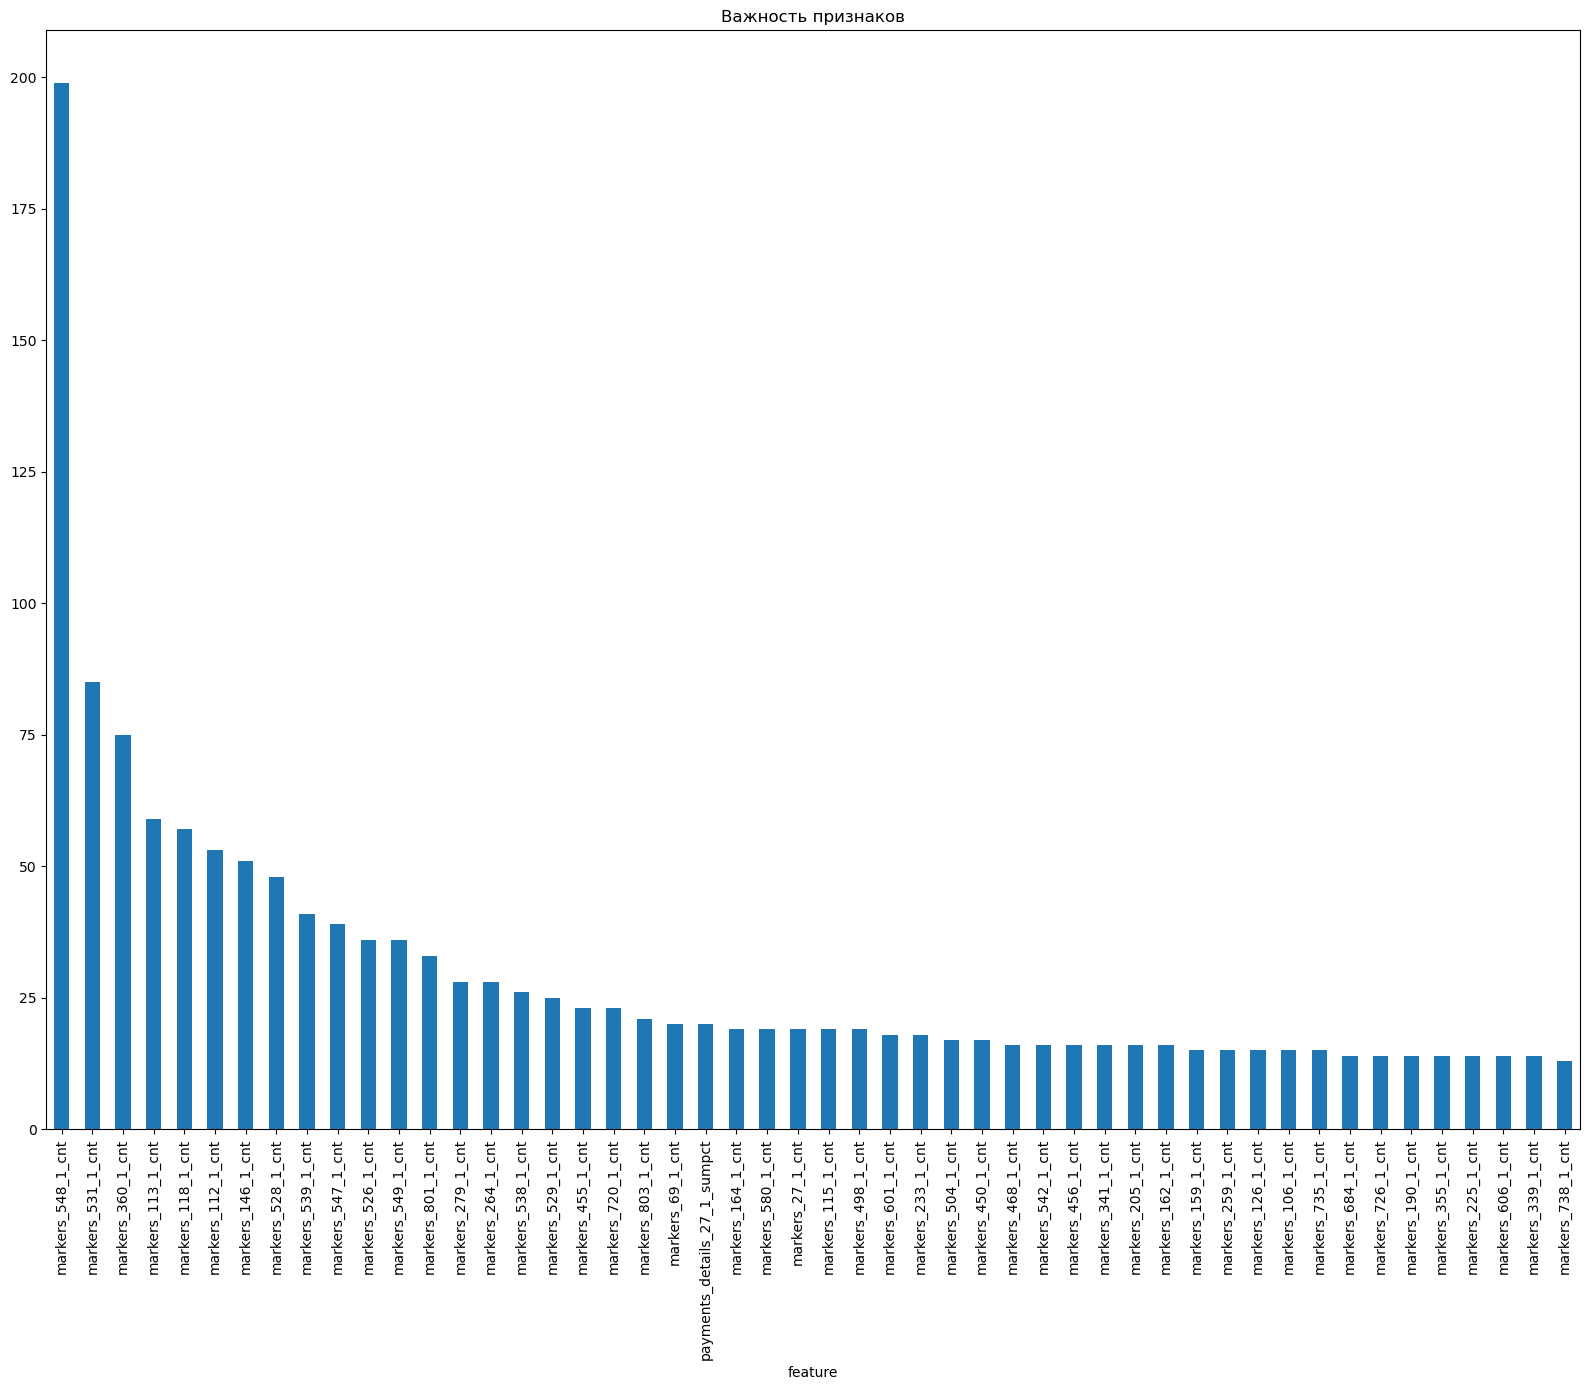

In [51]:
lgbm_imp = pd.Series(feature_importance, balanced_importance_df['feature'])

fig, ax = plt.subplots(figsize=(16,14))
lgbm_imp.sort_values(ascending=False).head(50).plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

### Отбираем признаки

In [53]:
# сохраним результаты
for_now = balanced_importance_df['feature'].head(50).to_list()
for_now

['charges_details_14_6_avg',
 'communication_availability_3_1_flg',
 'markers_706_1_cnt',
 'channel_name',
 'user_devices_0_1_cnt',
 'payments_details_46_1_sum',
 'markers_40_1_cnt',
 'materials_details_0_1_ctg',
 'payments_details_48_3_sum',
 'charges_details_16_3_avg',
 'payments_details_29_6_sumpct',
 'balance_details_0_1_num',
 'markers_508_1_cnt',
 'markers_434_1_cnt',
 'markers_387_1_cnt',
 'payments_details_49_6_avg',
 'materials_details_1_1_ctg',
 'markers_60_1_cnt',
 'markers_347_1_cnt',
 'markers_506_1_cnt',
 'markers_446_1_cnt',
 'markers_122_1_cnt',
 'markers_238_1_cnt',
 'markers_346_1_cnt',
 'markers_324_1_cnt',
 'charges_details_31_3_avg',
 'payments_details_23_3d6_avg',
 'markers_349_1_cnt',
 'payments_details_47_3_avg',
 'markers_376_1_cnt',
 'markers_629_1_cnt',
 'markers_310_1_cnt',
 'markers_65_1_cnt',
 'markers_622_1_cnt',
 'payments_details_16_1d3_avg',
 'charges_details_20_6_avg',
 'markers_721_1_cnt',
 'markers_338_1_cnt',
 'markers_522_1_cnt',
 'markers_146_1_c

In [54]:
# Получение матрицы ошибок
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Создание pd.DataFrame для матрицы ошибок
data = {'Прогноз (+)': [tp, fp], 'Прогноз (-)': [fn, tn]}
index = ['Реальность (+)', 'Реальность (-)']
conf_matrix = pd.DataFrame(data=data, index=index)

# Вывод матрицы ошибок
print(conf_matrix)

                Прогноз (+)  Прогноз (-)
Реальность (+)          878          489
Реальность (-)        52204       121951
